# Predict Future Sales - Features, XGBoost, LightGBM, RF, CatBoost

In [2]:
## Load library 
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from datetime import datetime, timedelta
from category_encoders import TargetEncoder 
import xgboost as xgb
import catboost as catb

np.random.seed(123)

# Load data
sales_train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
items = pd.read_csv('data/items.csv')
item_cat = pd.read_csv('data/item_categories.csv')
shops = pd.read_csv('data/shops.csv')

## Load translated data
shops_trans = pd.read_csv('data/shops-translated.csv')
items_trans = pd.read_csv('data/items-translated.csv')
item_cat_trans = pd.read_csv('data/item_categories-translated.csv')

In [3]:
## Function to downcast data

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
                
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
                
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    
    return df  

## Main Data Creation

Create matrix with all combinations of month-shop-item. This creates a grid of all possible shop-item combinations for each month, even if they were not sold during that month. 

In [3]:
%%time

from itertools import product

grid = []
index_cols = ['date_block_num', 'shop_id', 'item_id']
for i in sales_train['date_block_num'].unique():
    sales_temp = sales_train[sales_train.date_block_num == i]
    grid.append(np.array(list(product([i], sales_temp.shop_id.unique(), sales_temp.item_id.unique() )), dtype=np.int16))
    
grid = pd.DataFrame(np.vstack(grid), columns=index_cols)
grid.sort_values(index_cols, inplace=True)

Wall time: 9.41 s


In [4]:
grid.head(10)

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32
138948,0,0,33
138949,0,0,34
139247,0,0,35
142672,0,0,40
142065,0,0,41


Aggregate `sales_train` to monthly.

In [5]:
%%time 

# Item revenue
sales_train['item_rev'] = sales_train['item_cnt_day'] * sales_train['item_price']

aggregate = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])\
.agg({'item_cnt_day':'sum', 'item_price':'mean', 'item_rev':'mean'})\
.reset_index()\
.rename(columns = {'item_cnt_day':'item_cnt_month'})

Wall time: 823 ms


In [6]:
aggregate.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
item_price        0
item_rev          0
dtype: int64

Merge aggregate data with grid of all month-shop-item combinations. For those shop-item combinations that were not sold during a month, `item_cnt_month`, `item_price` and `item_rev` are all 0. 

In [7]:
%%time

grid = pd.merge(grid, aggregate, on=index_cols, how='left')
grid['item_cnt_month'] = (grid['item_cnt_month'].fillna(0).clip(0,20))
grid['item_price'] = (grid['item_price'].fillna(0))
grid['item_rev'] = (grid['item_rev'].fillna(0))

grid = downcast(grid)

Wall time: 4.01 s


In [8]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev
0,0,0,19,0.0,0.0,0.0
1,0,0,27,0.0,0.0,0.0
2,0,0,28,0.0,0.0,0.0
3,0,0,29,0.0,0.0,0.0
4,0,0,32,6.0,221.0,331.5
5,0,0,33,3.0,347.0,347.0
6,0,0,34,0.0,0.0,0.0
7,0,0,35,1.0,247.0,247.0
8,0,0,40,0.0,0.0,0.0
9,0,0,41,0.0,0.0,0.0


In [9]:
grid.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
item_price        0
item_rev          0
dtype: int64

Create test dataset with `date_block_num`=34 and concatenate with train dataset. Fill NA values from test data with zeros. This gives us the entire dataset to train the model on for all month-sho-item combinations. 

In [10]:
%%time

test['date_block_num'] = 34

grid = pd.concat([grid, test.drop(['ID'], axis=1)], ignore_index=True, sort=False, keys=index_cols)
grid.fillna(0, inplace=True)

Wall time: 332 ms


In [11]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev
0,0,0,19,0.0,0.0,0.0
1,0,0,27,0.0,0.0,0.0
2,0,0,28,0.0,0.0,0.0
3,0,0,29,0.0,0.0,0.0
4,0,0,32,6.0,221.0,331.5
5,0,0,33,3.0,347.0,347.0
6,0,0,34,0.0,0.0,0.0
7,0,0,35,1.0,247.0,247.0
8,0,0,40,0.0,0.0,0.0
9,0,0,41,0.0,0.0,0.0


In [12]:
grid.isna().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_month    0
item_price        0
item_rev          0
dtype: int64

In [13]:
grid = downcast(grid)

print(grid.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int8   
 1   shop_id         int8   
 2   item_id         int16  
 3   item_cnt_month  float16
 4   item_price      float32
 5   item_rev        float32
dtypes: float16(1), float32(2), int16(1), int8(2)
memory usage: 148.6 MB
None


Merge with supplemental information on shop names, item names and item category id. Use translated data for the names. 

In [14]:
%%time

grid = grid.merge(items, on='item_id')
grid = grid.merge(items_trans, on='item_id')
grid = grid.merge(item_cat_trans, on='item_category_id')
grid = grid.merge(shops_trans, on='shop_id')

grid = downcast(grid)

Wall time: 12.1 s


In [15]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs"


In [16]:
grid.isna().sum()

date_block_num                   0
shop_id                          0
item_id                          0
item_cnt_month                   0
item_price                       0
item_rev                         0
item_name                        0
item_category_id                 0
item_name_translated             0
item_category_name_translated    0
shop_name_translated             0
dtype: int64

In [17]:
print(grid.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 11 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   date_block_num                 int8    
 1   shop_id                        int8    
 2   item_id                        int16   
 3   item_cnt_month                 float16 
 4   item_price                     float32 
 5   item_rev                       float32 
 6   item_name                      category
 7   item_category_id               int8    
 8   item_name_translated           category
 9   item_category_name_translated  category
 10  shop_name_translated           category
dtypes: category(4), float16(1), float32(2), int16(1), int8(3)
memory usage: 309.4 MB
None


## Features

### Target variable lags
At the shop-item level. 

In [18]:
## Function to create lags
def create_lags(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        shifted = temp.copy()
        shifted.columns = ['date_block_num', 'shop_id', 'item_id', col+str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, on=['date_block_num', 'shop_id', 'item_id'], how='left')
        
        df = downcast(df)
        
    return df

In [19]:
%%time

grid = create_lags(grid, [1,2,3,6,12], 'item_cnt_month')

Wall time: 33 s


In [20]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,shop_name_translated,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month6,item_cnt_month12
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",6.0,NaN,NaN,NaN,NaN
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,NaN,NaN
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",1.0,NaN,NaN,NaN,NaN
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",NaN,NaN,NaN,NaN,NaN
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,"Yakutsk Ordzhonikidze, 56 francs",0.0,NaN,NaN,NaN,NaN


### Item Price Lags

In [ ]:
# %%time

# grid = create_lags(grid, [1,2,3,6,12], 'item_price')

### Item Revenue lags

In [ ]:
# %%time 

# grid = create_lags(grid, [1,2,3,6,12], 'item_rev')

In [ ]:
# grid.head(10)

### New Categorical Features

Create 3 new categorical variables: `city`, `item_type` and `item_subtype`. Label encode these variables. 

In [21]:
%%time

# Create new categorical variables
grid['city'] = grid['shop_name_translated'].str.split(expand=True)[0]
grid['item_type'] = grid['item_category_name_translated'].str.split(pat='-', expand=True)[0]
grid['item_subtype'] = grid['item_category_name_translated'].str.split(pat='-', expand=True)[1]

grid = downcast(grid)

# Label encode new cat variables 
labelcols = ['city', 'item_type', 'item_subtype']
for col in labelcols:
    grid[f'{col}_id'] = grid[col].cat.codes.astype('int16')
    grid[f'{col}_id'] -= grid[f'{col}_id'].min()

Wall time: 29.5 s


In [22]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,item_cnt_month2,item_cnt_month3,item_cnt_month6,item_cnt_month12,city,item_type,item_subtype,city_id,item_type_id,item_subtype_id
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22


### Mean Encoding Categorical Features
Use `item_cnt_month`, the target variable to mean encode. Also known as target encoding (?).

In [23]:
## Function to mean encode
# Take as arguments: data, cols to group by, target variable to calculate mean, new column name

def create_means(df, gcols, tcol, newcol):
    group = df.groupby(gcols)\
    .agg({tcol:'mean'})\
    .reset_index()\
    .rename(columns = {tcol:newcol})
    
    df = df.merge(group, on=gcols, how='left')
    df = downcast(df)
    
    return df

#### 1. Monthly sales

In [24]:
%%time 

grid = create_means(grid, ['date_block_num'], 'item_cnt_month', 'avg_sales')

Wall time: 3.98 s


In [25]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,item_cnt_month3,item_cnt_month6,item_cnt_month12,city,item_type,item_subtype,city_id,item_type_id,item_subtype_id,avg_sales
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463


#### 2. Monthly sales: 1 and 12 month lags

In [26]:
%%time

grid = create_lags(grid, [1,12], 'avg_sales')

Wall time: 16.3 s


In [27]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,item_cnt_month12,city,item_type,item_subtype,city_id,item_type_id,item_subtype_id,avg_sales,avg_sales1,avg_sales12
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463,0.347168,NaN
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463,0.347168,NaN
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463,0.347168,NaN
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.347168,NaN,NaN
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,Yakutsk,Cinema,DVD,30,3,22,0.324463,0.347168,NaN


#### 3. Average monthly sales by
1. shop
2. item
3. item category
4. city 
5. item type
6. item subtype

In [28]:
%%time 

cat_feats = ['shop', 'item', 'item_category', 'city', 'item_type', 'item_subtype']

for cat in cat_feats:
    grid = create_means(grid, ['date_block_num', cat+'_id'], 'item_cnt_month', 'avg_'+cat+'_sales')

Wall time: 35.4 s


In [29]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,item_subtype_id,avg_sales,avg_sales1,avg_sales12,avg_shop_sales,avg_item_sales,avg_item_category_sales,avg_city_sales,avg_item_type_sales,avg_item_subtype_sales
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,0.022217,0.293945,0.514160,0.271729,0.293945
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,5.378906,0.293945,0.514160,0.271729,0.293945
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,22,0.324463,0.347168,NaN,0.712402,4.476562,0.266113,0.559082,0.248169,0.266113
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,0.199951,0.293945,0.514160,0.271729,0.293945
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,22,0.324463,0.347168,NaN,0.712402,0.239136,0.266113,0.559082,0.248169,0.266113
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,1.733398,0.293945,0.514160,0.271729,0.293945
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,22,0.324463,0.347168,NaN,0.712402,2.587891,0.266113,0.559082,0.248169,0.266113
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,0.044434,0.293945,0.514160,0.271729,0.293945
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,22,0.347168,NaN,NaN,0.666992,0.088867,0.293945,0.514160,0.271729,0.293945
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,22,0.324463,0.347168,NaN,0.712402,0.043488,0.266113,0.559082,0.248169,0.266113


#### 4. Average monthly sales by
1. shop-item category
2. shop-item type
3. shop-item subtype
4. city-item

In [30]:
%%time

grid = create_means(grid, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'avg_shop_cat_sales')
grid = create_means(grid, ['date_block_num', 'shop_id', 'item_type_id'], 'item_cnt_month', 'avg_shop_type_sales')
grid = create_means(grid, ['date_block_num', 'shop_id', 'item_subtype_id'], 'item_cnt_month', 'avg_shop_subtype_sales')
grid = create_means(grid, ['date_block_num', 'item_id', 'city_id'], 'item_cnt_month', 'avg_item_city_sales')

Wall time: 35.1 s


In [31]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,avg_shop_sales,avg_item_sales,avg_item_category_sales,avg_city_sales,avg_item_type_sales,avg_item_subtype_sales,avg_shop_cat_sales,avg_shop_type_sales,avg_shop_subtype_sales,avg_item_city_sales
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,0.666992,0.022217,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,0.0
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,0.666992,5.378906,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,6.5
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,0.712402,4.476562,0.266113,0.559082,0.248169,0.266113,0.696777,0.633789,0.696777,6.5
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.666992,0.199951,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,0.0
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.712402,0.239136,0.266113,0.559082,0.248169,0.266113,0.696777,0.633789,0.696777,0.0
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.666992,1.733398,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,0.5
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.712402,2.587891,0.266113,0.559082,0.248169,0.266113,0.696777,0.633789,0.696777,8.5
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,0.666992,0.044434,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,0.5
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.666992,0.088867,0.293945,0.514160,0.271729,0.293945,0.739746,0.657715,0.739746,0.0
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.712402,0.043488,0.266113,0.559082,0.248169,0.266113,0.696777,0.633789,0.696777,0.0


#### 5. Average monthly sales lags per
1. shop: 1, 2, 3, 6, 12 month lags
2. item: 1, 2, 3, 6, 12 month lags
3. item category: 1 and 12 month lags
4. city: 1 and 12 month lags
5. item type: 1 and 12 month lags
6. item subtype: 1 and 12 month lags
7. shop-item category: 1 and 12 month lags
8. shop-item type: 1 and 12 month lags
9. shop-item subtype: 1 and 12 month lags
10. city-item: 1 and 12 month lags

In [32]:
%%time

grid = create_lags(grid, [1,2,3,6,12], 'avg_shop_sales')
grid = create_lags(grid, [1,2,3,6,12], 'avg_item_sales')
grid = create_lags(grid, [1,12], 'avg_item_category_sales')
grid = create_lags(grid, [1,12], 'avg_city_sales')
grid = create_lags(grid, [1,12], 'avg_item_type_sales')
grid = create_lags(grid, [1,12], 'avg_item_subtype_sales')
grid = create_lags(grid, [1,12], 'avg_shop_cat_sales')
grid = create_lags(grid, [1,12], 'avg_shop_type_sales')
grid = create_lags(grid, [1,12], 'avg_shop_subtype_sales')
grid = create_lags(grid, [1,12], 'avg_item_city_sales')

Wall time: 4min 58s


In [33]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,avg_item_subtype_sales1,avg_item_subtype_sales12,avg_shop_cat_sales1,avg_shop_cat_sales12,avg_shop_type_sales1,avg_shop_type_sales12,avg_shop_subtype_sales1,avg_shop_subtype_sales12,avg_item_city_sales1,avg_item_city_sales12
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,0.293945,NaN,0.739746,NaN,0.657715,NaN,0.739746,NaN,6.5,NaN
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.293945,NaN,0.739746,NaN,0.657715,NaN,0.739746,NaN,0.0,NaN
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.293945,NaN,0.739746,NaN,0.657715,NaN,0.739746,NaN,0.5,NaN
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.293945,NaN,0.739746,NaN,0.657715,NaN,0.739746,NaN,0.0,NaN


### Price Trends

#### 1. Last month item price trend

In [39]:
%%time

# Create mean price by item
grid = create_means(grid, ['item_id'], 'item_price', 'avg_item_price')

# Create monthly mean price by item
grid = create_means(grid, ['date_block_num', 'item_id'], 'item_price', 'avg_item_price_month')

# Price deviation 
grid['delta_price_item'] = (grid['avg_item_price_month'] - grid['avg_item_price']) / grid['avg_item_price']

# 1 month lag of price deviation
grid = create_lags(grid, [1], 'delta_price_item')

Wall time: 41.1 s


In [40]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,avg_shop_type_sales1,avg_shop_type_sales12,avg_shop_subtype_sales1,avg_shop_subtype_sales12,avg_item_city_sales1,avg_item_city_sales12,avg_item_price,avg_item_price_month,delta_price_item,delta_price_item1
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,0.622070,0.622070,0.000000,NaN
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,106.750000,275.500000,1.581055,NaN
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,0.657715,NaN,0.739746,NaN,6.5,NaN,106.750000,269.500000,1.524414,1.581055
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,18.125000,24.859375,0.371582,NaN
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.657715,NaN,0.739746,NaN,0.0,NaN,18.125000,29.156250,0.608398,0.371582
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,120.562500,206.000000,0.708496,NaN
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.657715,NaN,0.739746,NaN,0.5,NaN,120.562500,295.750000,1.453125,0.708496
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,5.492188,10.421875,0.897461,NaN
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,NaN,NaN,NaN,NaN,7.937500,13.078125,0.647461,NaN
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.657715,NaN,0.739746,NaN,0.0,NaN,7.937500,6.476562,-0.184082,0.647461


#### 2. Last month shop price trend

In [41]:
%%time 

# Create mean price by shop
grid = create_means(grid, ['shop_id'], 'item_price', 'avg_shop_price')

# Create monthly mean price by item
grid = create_means(grid, ['date_block_num', 'shop_id'], 'item_price', 'avg_shop_price_month')

# Price deviation 
grid['delta_price_shop'] = (grid['avg_shop_price_month'] - grid['avg_shop_price']) / grid['avg_shop_price']

# 1 month lag of price deviation
grid = create_lags(grid, [1], 'delta_price_shop')

Wall time: 43.7 s


In [42]:
grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,avg_item_city_sales1,avg_item_city_sales12,avg_item_price,avg_item_price_month,delta_price_item,delta_price_item1,avg_shop_price,avg_shop_price_month,delta_price_shop,delta_price_shop1
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,NaN,NaN,0.622070,0.622070,0.000000,NaN,136.625,129.875,-0.049408,NaN
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,NaN,NaN,106.750000,275.500000,1.581055,NaN,136.625,129.875,-0.049408,NaN
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,6.5,NaN,106.750000,269.500000,1.524414,1.581055,136.625,143.375,0.049408,-0.049408
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,NaN,NaN,18.125000,24.859375,0.371582,NaN,136.625,129.875,-0.049408,NaN
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.0,NaN,18.125000,29.156250,0.608398,0.371582,136.625,143.375,0.049408,-0.049408
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,NaN,NaN,120.562500,206.000000,0.708496,NaN,136.625,129.875,-0.049408,NaN
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.5,NaN,120.562500,295.750000,1.453125,0.708496,136.625,143.375,0.049408,-0.049408
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,NaN,NaN,5.492188,10.421875,0.897461,NaN,136.625,129.875,-0.049408,NaN
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,NaN,NaN,7.937500,13.078125,0.647461,NaN,136.625,129.875,-0.049408,NaN
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.0,NaN,7.937500,6.476562,-0.184082,0.647461,136.625,143.375,0.049408,-0.049408


### Revenue Trends

#### 1. Last month shop revenue trend

### Other Special Features

#### Month variable

In [43]:
# Add a month variable
grid['month'] = (grid['date_block_num'] % 12) 

print(grid['month'].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11]


#### # days in month 

In [44]:
# Add number of days in the month
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
grid['days'] = grid['month'].map(days)

print(grid['days'].unique())

[31 28 30]


#### Months since first sale for each shop-item combination and item only

In [45]:
%%time

grid['shop_item_first_sale'] = grid['date_block_num'] - grid.groupby(['shop_id', 'item_id'])['date_block_num'].transform('min')

grid['item_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id'])['date_block_num'].transform('min')

Wall time: 2.21 s


In [46]:
grid = downcast(grid)

grid.head(10)

,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,item_category_name_translated,...,delta_price_item,delta_price_item1,avg_shop_price,avg_shop_price_month,delta_price_shop,delta_price_shop1,month,days,shop_item_first_sale,item_first_sale
0,0,0,19,0.0,0.0,0.000000,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,/ GOLDEN COLLECTION m / f-72,Cinema - DVD,...,0.000000,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
1,0,0,32,6.0,221.0,331.500000,1+1,40,1+1,Cinema - DVD,...,1.581055,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
2,1,0,32,10.0,221.0,315.714294,1+1,40,1+1,Cinema - DVD,...,1.524414,1.581055,136.625,143.375,0.049408,-0.049408,1,28,1,1
3,0,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.371582,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
4,1,0,34,0.0,0.0,0.000000,10 000 ЛЕТ ДО НАШЕЙ ЭРЫ WB (регион),40,10 000 YEARS OLDER OUR WB (region),Cinema - DVD,...,0.608398,0.371582,136.625,143.375,0.049408,-0.049408,1,28,1,1
5,0,0,35,1.0,247.0,247.000000,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,0.708496,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
6,1,0,35,14.0,247.0,314.363647,10 ЛЕТ СПУСТЯ,40,10 YEARS LATER,Cinema - DVD,...,1.453125,0.708496,136.625,143.375,0.049408,-0.049408,1,28,1,1
7,0,0,43,1.0,221.0,221.000000,100 МИЛЛИОНОВ ЕВРО,40,100 MILLION EURO,Cinema - DVD,...,0.897461,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
8,0,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,0.647461,NaN,136.625,129.875,-0.049408,NaN,0,31,0,0
9,1,0,63,0.0,0.0,0.000000,101 ДАЛМАТИНЕЦ wd,40,101 DALMATINE wd,Cinema - DVD,...,-0.184082,0.647461,136.625,143.375,0.049408,-0.049408,1,28,1,1


### Final Data for modelling
Drop first 12 months of data since max lag value used is 12. 

In [47]:
%%time

grid = grid[grid.date_block_num > 11]

Wall time: 1.35 s


In [48]:
grid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 32579 to 11128049
Data columns (total 73 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   date_block_num                 int8    
 1   shop_id                        int8    
 2   item_id                        int16   
 3   item_cnt_month                 float16 
 4   item_price                     float32 
 5   item_rev                       float32 
 6   item_name                      category
 7   item_category_id               int8    
 8   item_name_translated           category
 9   item_category_name_translated  category
 10  shop_name_translated           category
 11  item_cnt_month1                float16 
 12  item_cnt_month2                float16 
 13  item_cnt_month3                float16 
 14  item_cnt_month6                float16 
 15  item_cnt_month12               float16 
 16  city                           category
 17  item_type             

In [49]:
grid.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_price',
       'item_rev', 'item_name', 'item_category_id', 'item_name_translated',
       'item_category_name_translated', 'shop_name_translated',
       'item_cnt_month1', 'item_cnt_month2', 'item_cnt_month3',
       'item_cnt_month6', 'item_cnt_month12', 'city', 'item_type',
       'item_subtype', 'city_id', 'item_type_id', 'item_subtype_id',
       'avg_sales', 'avg_sales1', 'avg_sales12', 'avg_shop_sales',
       'avg_item_sales', 'avg_item_category_sales', 'avg_city_sales',
       'avg_item_type_sales', 'avg_item_subtype_sales', 'avg_shop_cat_sales',
       'avg_shop_type_sales', 'avg_shop_subtype_sales', 'avg_item_city_sales',
       'avg_shop_sales1', 'avg_shop_sales2', 'avg_shop_sales3',
       'avg_shop_sales6', 'avg_shop_sales12', 'avg_item_sales1',
       'avg_item_sales2', 'avg_item_sales3', 'avg_item_sales6',
       'avg_item_sales12', 'avg_item_category_sales1',
       'avg_item_category_sales12', 'av

## Model - XGBoost

In [50]:
%%time

grid.to_csv('data/model_fit_data_1.csv')

Wall time: 4min 50s


`date_block_num` 12-33 is train set, `date_block_num`=33 is the validation set and `date_block_num`=34 is the test set. 

In [53]:
del_cols=['item_cnt_month', 'item_name', 'item_name_translated', 'item_category_name_translated', 'shop_name_translated', 
          'city', 'item_type', 'item_subtype'] + ['item_price', 'item_rev', 'avg_sales', 'avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales', 'avg_city_sales', 
 'avg_item_type_sales', 'avg_item_subtype_sales', 'avg_shop_cat_sales','avg_shop_type_sales', 'avg_shop_subtype_sales', 
 'avg_item_city_sales', 'avg_item_price', 'avg_item_price_month', 'avg_shop_price', 'avg_shop_price_month']

In [54]:
del_cols

['item_cnt_month',
 'item_name',
 'item_name_translated',
 'item_category_name_translated',
 'shop_name_translated',
 'city',
 'item_type',
 'item_subtype',
 'item_price',
 'item_rev',
 'avg_sales',
 'avg_shop_sales',
 'avg_item_sales',
 'avg_item_category_sales',
 'avg_city_sales',
 'avg_item_type_sales',
 'avg_item_subtype_sales',
 'avg_shop_cat_sales',
 'avg_shop_type_sales',
 'avg_shop_subtype_sales',
 'avg_item_city_sales',
 'avg_item_price',
 'avg_item_price_month',
 'avg_shop_price',
 'avg_shop_price_month']

In [55]:
X_train = grid[grid.date_block_num < 33].drop(del_cols, axis=1)
y_train = grid[grid.date_block_num < 33]['item_cnt_month']
X_valid = grid[grid.date_block_num == 33].drop(del_cols, axis=1)
y_valid = grid[grid.date_block_num == 33]['item_cnt_month']
X_test = grid[grid.date_block_num == 34].drop(del_cols, axis=1)

In [56]:
del grid
gc.collect();

In [58]:
%%time 

model = xgb.XGBRegressor(
    max_depth=10, 
    n_estimators=1000, 
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3, 
    seed=42, 
    n_jobs=15)

model.fit(
    X_train, 
    y_train, 
    eval_metric='rmse', 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds=10)

[13:29:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:29:21] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.14415	validation_1-rmse:1.11365
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08978	validation_1-rmse:1.07427
[2]	validation_0-rmse:1.0427	validation_1-rmse:1.04166
[3]	validation_0-rmse:1.00503	validation_1-rmse:1.01436
[4]	validation_0-rmse:0.969297	validation_1-rmse:0.992635
[5]	validation_0-rmse:0.939321	validation_1-rmse:0.972858
[6]	validation_0-rmse:0.914751	validation_1-rmse:0.958805
[7]	validation_0-rmse:0.891563	validation_1-rmse:0.947106
[8]	validation_0-rmse:0.872536	validation_1-rmse:0.936287
[9]	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=0.5, missing=None,
             n_estimators=1000, n_jobs=15, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.8, verbosity=1)

In [59]:
%%time

# Predict
y_pred = model.predict(X_valid).clip(0,20)
y_test = model.predict(X_test).clip(0,20)

Wall time: 345 ms


In [60]:
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':y_test})
submission.to_csv('xgb_submission2.csv', index=False)

In [61]:
submission.shape

(214200, 2)

In [62]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

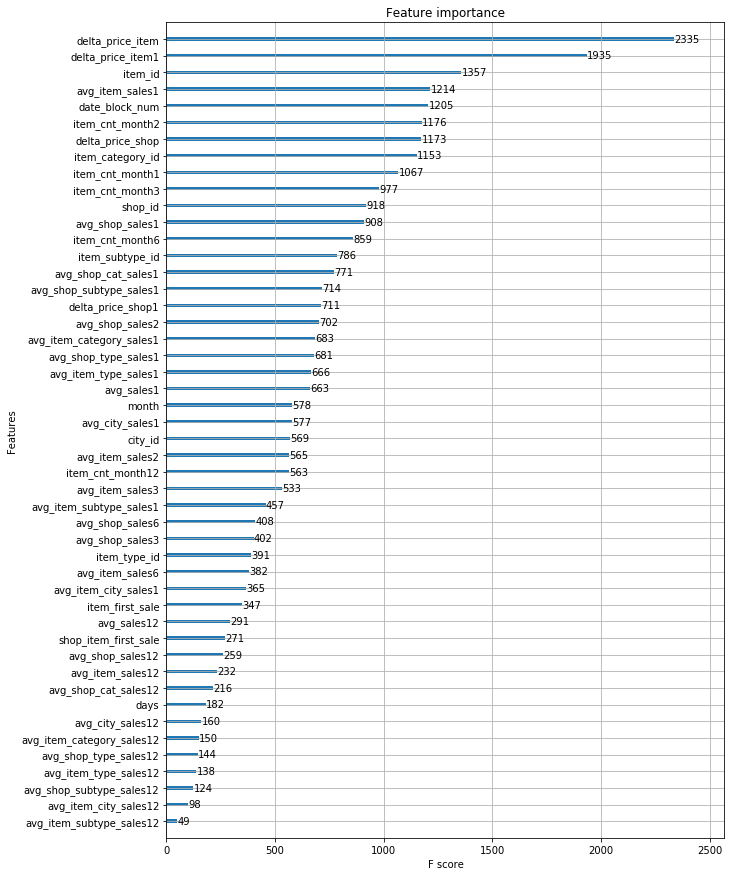

In [63]:
plot_features(model, (10,15))

## Model - LightGBM

In [21]:
%%time 

grid = pd.read_csv('data/model_fit_data_1.csv')

Wall time: 31.4 s


In [22]:
grid.head(10)

,Unnamed: 0,date_block_num,shop_id,item_id,item_cnt_month,item_price,item_rev,item_name,item_category_id,item_name_translated,...,delta_price_item,delta_price_item1,avg_shop_price,avg_shop_price_month,delta_price_shop,delta_price_shop1,month,days,shop_item_first_sale,item_first_sale
0,32579,12,2,32,1.0,119.0,119.0,1+1,40,1+1,...,-0.11066,-0.07610,79.75,70.10,-0.12067,0.04388,0,31,12,12
1,32580,13,2,32,0.0,0.0,0.0,1+1,40,1+1,...,-0.39280,-0.11066,79.75,68.20,-0.14500,-0.12067,1,28,13,13
2,32581,14,2,32,1.0,149.0,149.0,1+1,40,1+1,...,-0.27300,-0.39280,79.75,83.25,0.04388,-0.14500,2,31,14,14
3,32582,15,2,32,0.0,0.0,0.0,1+1,40,1+1,...,-0.53000,-0.27300,79.75,75.06,-0.05878,0.04388,3,30,15,15
4,32583,16,2,32,0.0,0.0,0.0,1+1,40,1+1,...,-0.57280,-0.53000,79.75,82.90,0.03918,-0.05878,4,31,16,16
5,32584,17,2,32,0.0,0.0,0.0,1+1,40,1+1,...,-0.57280,-0.57280,79.75,72.56,-0.09015,0.03918,5,30,17,17
6,32585,18,2,32,1.0,149.0,149.0,1+1,40,1+1,...,-0.70650,-0.57280,79.75,70.10,-0.12067,-0.09015,6,31,18,18
7,32586,19,2,32,0.0,0.0,0.0,1+1,40,1+1,...,-0.53470,-0.70650,79.75,74.50,-0.06586,-0.12067,7,31,19,19
8,32587,20,2,32,2.0,149.0,149.0,1+1,40,1+1,...,-0.38570,-0.53470,79.75,81.44,0.02116,-0.06586,8,30,20,20
9,32588,21,2,32,2.0,149.0,149.0,1+1,40,1+1,...,-0.49000,-0.38570,79.75,103.20,0.29400,0.02116,9,31,21,21


In [6]:
grid.columns

Index(['Unnamed: 0', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price', 'item_rev', 'item_name', 'item_category_id',
       'item_name_translated', 'item_category_name_translated',
       'shop_name_translated', 'item_cnt_month1', 'item_cnt_month2',
       'item_cnt_month3', 'item_cnt_month6', 'item_cnt_month12', 'city',
       'item_type', 'item_subtype', 'city_id', 'item_type_id',
       'item_subtype_id', 'avg_sales', 'avg_sales1', 'avg_sales12',
       'avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales',
       'avg_city_sales', 'avg_item_type_sales', 'avg_item_subtype_sales',
       'avg_shop_cat_sales', 'avg_shop_type_sales', 'avg_shop_subtype_sales',
       'avg_item_city_sales', 'avg_shop_sales1', 'avg_shop_sales2',
       'avg_shop_sales3', 'avg_shop_sales6', 'avg_shop_sales12',
       'avg_item_sales1', 'avg_item_sales2', 'avg_item_sales3',
       'avg_item_sales6', 'avg_item_sales12', 'avg_item_category_sales1',
       'avg_item_category

In [7]:
del_cols=['Unnamed: 0', 'item_cnt_month', 'item_name', 'item_name_translated', 'item_category_name_translated', 'shop_name_translated', 
          'city', 'item_type', 'item_subtype'] + ['item_price', 'item_rev', 'avg_sales', 'avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales', 'avg_city_sales', 
 'avg_item_type_sales', 'avg_item_subtype_sales', 'avg_shop_cat_sales','avg_shop_type_sales', 'avg_shop_subtype_sales', 
 'avg_item_city_sales', 'avg_item_price', 'avg_item_price_month', 'avg_shop_price', 'avg_shop_price_month']

In [11]:
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id']

In [8]:
X_train = grid[grid.date_block_num < 33].drop(del_cols, axis=1)
y_train = grid[grid.date_block_num < 33]['item_cnt_month']
X_valid = grid[grid.date_block_num == 33].drop(del_cols, axis=1)
y_valid = grid[grid.date_block_num == 33]['item_cnt_month']
X_test = grid[grid.date_block_num == 34].drop(del_cols, axis=1)

In [10]:
del grid
gc.collect();

In [13]:
%%time

# Data to fit model 
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols, free_raw_data=False)

# Data for validation
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols, free_raw_data=False)

Wall time: 0 ns


In [23]:
%%time

# Hyperparameters
params = {'objective':'poisson', 
          'metric':'rmse', 
          'force_row_wise':True, 
          'learning_rate':0.075, 
          'bagging_fraction':0.75, 
          'bagging_freq':1, 
          'lambda_l2':0.1, 
          'verbosity':1, 
          'num_iterations':1500, #1500
          'num_leaves':128, #128
          'min_data_in_leaf':100 #100
         }

model_lgb = lgb.train(params, train_set=train_data, valid_sets=[valid_data], verbose_eval=20)

C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\Soumya Chatterjee\anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 0.941067
[40]	valid_0's rmse: 0.900934
[60]	valid_0's rmse: 0.895062
[80]	valid_0's rmse: 0.896278
[100]	valid_0's rmse: 0.897348
[120]	valid_0's rmse: 0.899404
[140]	valid_0's rmse: 0.900954
[160]	valid_0's rmse: 0.901545
[180]	valid_0's rmse: 0.902441
[200]	valid_0's rmse: 0.903049
[220]	valid_0's rmse: 0.903491
[240]	valid_0's rmse: 0.903847
[260]	valid_0's rmse: 0.904107
[280]	valid_0's rmse: 0.904183
[300]	valid_0's rmse: 0.904225
[320]	valid_0's rmse: 0.903823
[340]	valid_0's rmse: 0.904256
[360]	valid_0's rmse: 0.904254
[380]	valid_0's rmse: 0.904325
[400]	valid_0's rmse: 0.904124
[420]	valid_0's rmse: 0.903619
[440]	valid_0's rmse: 0.903757
[460]	valid_0's rmse: 0.904058
[480]	valid_0's rmse: 0.904369
[500]	valid_0's rmse: 0.904432
[520]	valid_0's rmse: 0.904244
[540]	valid_0's rmse: 0.904144
[560]	valid_0's rmse: 0.904384
[580]	valid_0's rmse: 0.904337
[600]	valid_0's rmse: 0.904465
[620]	valid_0's rmse: 0.90466
[640]	valid_0's rmse: 0.905063
[660]	valid_0

In [24]:
from lightgbm import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

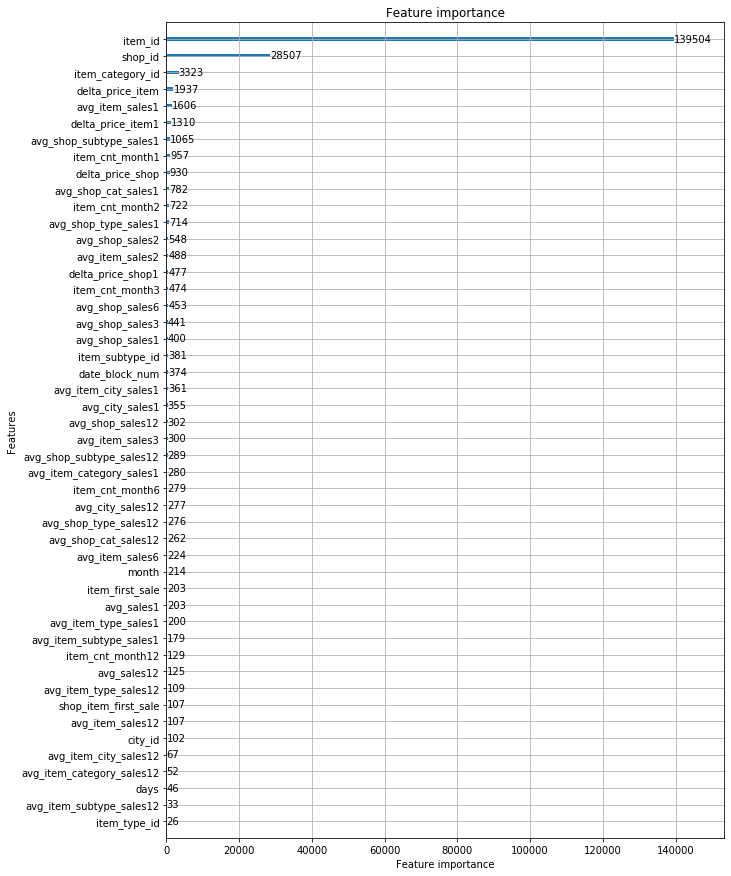

In [25]:
plot_features(model_lgb, (10,15))

In [26]:
%%time

# Predict
y_pred = model_lgb.predict(X_valid).clip(0,20)
y_test = model_lgb.predict(X_test).clip(0,20)

Wall time: 1min 46s


In [27]:
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':y_test})
submission.to_csv('lgb_submission2.csv', index=False)

In [28]:
submission.shape

(214200, 2)

## Model - Random Forest

In [48]:
%%time 

grid = pd.read_csv('data/model_fit_data_1.csv')

Wall time: 35.8 s


In [35]:
grid.columns

Index(['Unnamed: 0', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price', 'item_rev', 'item_name', 'item_category_id',
       'item_name_translated', 'item_category_name_translated',
       'shop_name_translated', 'item_cnt_month1', 'item_cnt_month2',
       'item_cnt_month3', 'item_cnt_month6', 'item_cnt_month12', 'city',
       'item_type', 'item_subtype', 'city_id', 'item_type_id',
       'item_subtype_id', 'avg_sales', 'avg_sales1', 'avg_sales12',
       'avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales',
       'avg_city_sales', 'avg_item_type_sales', 'avg_item_subtype_sales',
       'avg_shop_cat_sales', 'avg_shop_type_sales', 'avg_shop_subtype_sales',
       'avg_item_city_sales', 'avg_shop_sales1', 'avg_shop_sales2',
       'avg_shop_sales3', 'avg_shop_sales6', 'avg_shop_sales12',
       'avg_item_sales1', 'avg_item_sales2', 'avg_item_sales3',
       'avg_item_sales6', 'avg_item_sales12', 'avg_item_category_sales1',
       'avg_item_category

Use only categorical features and mean encoded features for random forest. Remove all features that have NA values, which are usually the lag features. 

In [54]:
rf_features = ['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'city_id', 'item_type_id', 'item_subtype_id', 
              'avg_sales', 'avg_shop_sales', 'avg_item_sales', 'avg_item_category_sales', 'avg_city_sales', 
               'avg_item_type_sales', 'avg_item_subtype_sales', 'avg_shop_cat_sales', 'avg_shop_type_sales', 
               'avg_shop_subtype_sales', 'avg_item_city_sales', 'delta_price_shop', 
               'month', 'days', 'shop_item_first_sale', 'item_first_sale']

rf_del_cols = grid.columns[~grid.columns.isin(rf_features)]

In [55]:
X_train_rf = grid[grid.date_block_num < 33].drop(rf_del_cols, axis=1)
y_train_rf = grid[grid.date_block_num < 33]['item_cnt_month']
X_valid_rf = grid[grid.date_block_num == 33].drop(rf_del_cols, axis=1)
y_valid_rf = grid[grid.date_block_num == 33]['item_cnt_month']
X_test_rf = grid[grid.date_block_num == 34].drop(rf_del_cols, axis=1)

In [59]:
del grid
gc.collect()

2468

In [60]:
%%time

from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(criterion='mse', 
                                 n_estimators=1000, 
                                 max_depth=10, 
                                 min_samples_leaf=0.5, 
                                 max_features=0.8, 
                                 min_samples_split=0.8, 
                                 random_state=42,
                                 n_jobs=15, 
                                 verbose=3)


model_rf.fit(X_train_rf, y_train_rf)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.


building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000

building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000building tree 7 of 1000


building tree 8 of 1000
building tree 9 of 1000building tree 10 of 1000

building tree 11 of 1000building tree 12 of 1000

building tree 13 of 1000building tree 14 of 1000

building tree 15 of 1000
building tree 16 of 1000building tree 17 of 1000
building tree 18 of 1000

building tree 19 of 1000building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000building tree 23 of 1000

[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.8s


building tree 24 of 1000

building tree 25 of 1000building tree 26 of 1000

building tree 27 of 1000


building tree 28 of 1000building tree 29 of 1000

building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000building tree 34 of 1000

building tree 35 of 1000building tree 36 of 1000building tree 37 of 1000building tree 38 of 1000building tree 39 of 1000building tree 40 of 1000



building tree 41 of 1000building tree 42 of 1000
building tree 43 of 1000



building tree 44 of 1000
building tree 45 of 1000
building tree 46 of 1000
building tree 47 of 1000
building tree 48 of 1000building tree 49 of 1000
building tree 50 of 1000building tree 51 of 1000building tree 52 of 1000
building tree 53 of 1000


building tree 54 of 1000building tree 55 of 1000building tree 56 of 1000



building tree 57 of 1000building tree 58 of 1000

building tree 59 of 1000
building tree 60 of 1000building tree 61 of 1000

building tree 62 of 1000
building tree 63 of 10

[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    8.5s


building tree 112 of 1000building tree 113 of 1000

building tree 114 of 1000building tree 115 of 1000
building tree 116 of 1000building tree 117 of 1000

building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000building tree 121 of 1000


building tree 122 of 1000building tree 123 of 1000

building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000building tree 129 of 1000

building tree 130 of 1000building tree 131 of 1000building tree 132 of 1000building tree 133 of 1000

building tree 134 of 1000building tree 135 of 1000


building tree 136 of 1000

building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000building tree 145 of 1000building tree 146 of 1000
building tree 147 of 1000

building tree 148 of 1000building tree 149 of 1000building tree 1

[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:   20.7s


building tree 287 of 1000
building tree 288 of 1000building tree 289 of 1000
building tree 290 of 1000

building tree 291 of 1000building tree 292 of 1000
building tree 293 of 1000building tree 294 of 1000building tree 295 of 1000building tree 296 of 1000


building tree 297 of 1000

building tree 298 of 1000building tree 299 of 1000building tree 300 of 1000building tree 301 of 1000




building tree 302 of 1000
building tree 303 of 1000
building tree 304 of 1000building tree 305 of 1000

building tree 306 of 1000
building tree 307 of 1000
building tree 308 of 1000building tree 309 of 1000

building tree 310 of 1000building tree 311 of 1000

building tree 312 of 1000building tree 313 of 1000building tree 314 of 1000building tree 315 of 1000building tree 316 of 1000
building tree 317 of 1000
building tree 318 of 1000




building tree 319 of 1000
building tree 320 of 1000
building tree 321 of 1000
building tree 322 of 1000building tree 323 of 1000
building tree 324 of 1000

building tre

[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:   38.2s


building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000building tree 515 of 1000building tree 516 of 1000building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000


building tree 520 of 1000
building tree 521 of 1000building tree 522 of 1000

building tree 523 of 1000

building tree 524 of 1000building tree 525 of 1000building tree 526 of 1000


building tree 527 of 1000building tree 528 of 1000

building tree 529 of 1000building tree 530 of 1000

building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000building tree 534 of 1000building tree 535 of 1000building tree 536 of 1000
building tree 537 of 1000
building tree 538 of 1000
building tree 539 of 1000



building tree 540 of 1000building tree 541 of 1000

building tree 542 of 1000building tree 543 of 1000building tree 544 of 1000building tree 545 of 1000



building tree 546 of 1000building tree 547 of 1000building tree 548 of 1000building tree 549 of 1000
building tree 5

[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:  1.0min


building tree 797 of 1000building tree 798 of 1000
building tree 799 of 1000building tree 800 of 1000


building tree 801 of 1000building tree 802 of 1000building tree 803 of 1000


building tree 804 of 1000building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000building tree 808 of 1000building tree 809 of 1000building tree 810 of 1000building tree 811 of 1000





building tree 812 of 1000building tree 813 of 1000
building tree 814 of 1000building tree 815 of 1000

building tree 816 of 1000building tree 817 of 1000
building tree 818 of 1000

building tree 819 of 1000
building tree 820 of 1000

building tree 821 of 1000building tree 822 of 1000building tree 823 of 1000
building tree 824 of 1000

building tree 825 of 1000building tree 826 of 1000


building tree 827 of 1000building tree 828 of 1000building tree 829 of 1000building tree 830 of 1000

building tree 831 of 1000building tree 832 of 1000
building tree 833 of 1000building tree 834 of 1000building tree 835

[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:  1.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.5,
                      min_samples_split=0.8, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=15, oob_score=False,
                      random_state=42, verbose=3, warm_start=False)

In [61]:
%%time

# Predict
y_train_pred_rf = model_rf.predict(X_train_rf).clip(0,20)
y_valid_pred_rf = model_rf.predict(X_valid_rf).clip(0,20)
y_test_rf = model_rf.predict(X_test_rf).clip(0,20)

[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    1.8s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    4.7s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    8.9s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:   14.3s
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:   18.5s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done  98 tasks      | elapsed:    0.0s
[Parallel(n_jobs=15)]: Done 258 tasks      | elapsed:    0.1s
[Parallel(n_jobs=15)]: Done 482 tasks      | elapsed:    0.3s
[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:    0.5s
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:    0.6s finished
[Parallel(n_jobs=15)]: Using backend ThreadingBackend with 15 concurre

Wall time: 21 s


[Parallel(n_jobs=15)]: Done 770 tasks      | elapsed:    0.4s
[Parallel(n_jobs=15)]: Done 1000 out of 1000 | elapsed:    0.6s finished


In [62]:
from sklearn.metrics import mean_squared_error

print('Train RMSE:', np.sqrt(mean_squared_error(y_train_rf, y_train_pred_rf)) )
print('Valid RMSE:', np.sqrt(mean_squared_error(y_valid_rf, y_valid_pred_rf)) )

Train RMSE: 1.188251671936376
Valid RMSE: 1.1365588735297323


In [63]:
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':y_test_rf})
submission.to_csv('rf_submission1.csv', index=False)

In [64]:
submission.shape

(214200, 2)

## Model - Catboost

In [66]:
import catboost as catb

In [68]:
%%time

model_catb = catb.CatBoostRegressor(eval_metric='RMSE', 
                                    iterations=1000, 
                                    learning_rate=0.3, 
                                    random_seed=123, 
                                    l2_leaf_reg=0.1, 
                                    depth=10, 
                                    min_data_in_leaf=0.5, 
                                    rsm=0.8, 
                                    thread_count=15, 
                                    verbose=True)

model_catb.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_valid, y_valid))

0:	learn: 1.0286028	test: 1.0451401	best: 1.0451401 (0)	total: 5.34s	remaining: 1h 28m 52s
1:	learn: 0.9352860	test: 0.9876121	best: 0.9876121 (1)	total: 10s	remaining: 1h 23m 10s
2:	learn: 0.8714352	test: 0.9590384	best: 0.9590384 (2)	total: 15s	remaining: 1h 22m 49s
3:	learn: 0.8292753	test: 0.9404000	best: 0.9404000 (3)	total: 19.9s	remaining: 1h 22m 23s
4:	learn: 0.8041128	test: 0.9329142	best: 0.9329142 (4)	total: 25s	remaining: 1h 22m 52s
5:	learn: 0.7873485	test: 0.9275288	best: 0.9275288 (5)	total: 29.4s	remaining: 1h 21m 9s
6:	learn: 0.7752038	test: 0.9264276	best: 0.9264276 (6)	total: 34.4s	remaining: 1h 21m 19s
7:	learn: 0.7659709	test: 0.9259853	best: 0.9259853 (7)	total: 39.6s	remaining: 1h 21m 52s
8:	learn: 0.7585357	test: 0.9245380	best: 0.9245380 (8)	total: 45.8s	remaining: 1h 24m 4s
9:	learn: 0.7543188	test: 0.9343985	best: 0.9245380 (8)	total: 51.7s	remaining: 1h 25m 20s
10:	learn: 0.7501027	test: 0.9558070	best: 0.9245380 (8)	total: 57.2s	remaining: 1h 25m 42s
11:	le

89:	learn: 0.6341409	test: 0.9553195	best: 0.9245380 (8)	total: 7m 48s	remaining: 1h 18m 56s
90:	learn: 0.6336056	test: 0.9532614	best: 0.9245380 (8)	total: 7m 54s	remaining: 1h 18m 57s
91:	learn: 0.6333126	test: 0.9531393	best: 0.9245380 (8)	total: 7m 58s	remaining: 1h 18m 41s
92:	learn: 0.6328696	test: 0.9525407	best: 0.9245380 (8)	total: 8m 4s	remaining: 1h 18m 42s
93:	learn: 0.6322636	test: 0.9526463	best: 0.9245380 (8)	total: 8m 9s	remaining: 1h 18m 41s
94:	learn: 0.6314683	test: 0.9540326	best: 0.9245380 (8)	total: 8m 16s	remaining: 1h 18m 48s
95:	learn: 0.6310055	test: 0.9546417	best: 0.9245380 (8)	total: 8m 23s	remaining: 1h 18m 57s
96:	learn: 0.6306492	test: 0.9547190	best: 0.9245380 (8)	total: 8m 29s	remaining: 1h 18m 58s
97:	learn: 0.6298574	test: 0.9525280	best: 0.9245380 (8)	total: 8m 35s	remaining: 1h 19m 3s
98:	learn: 0.6293525	test: 0.9527975	best: 0.9245380 (8)	total: 8m 39s	remaining: 1h 18m 49s
99:	learn: 0.6287600	test: 0.9683700	best: 0.9245380 (8)	total: 8m 44s	re

176:	learn: 0.5926492	test: 0.9840189	best: 0.9245380 (8)	total: 15m 34s	remaining: 1h 12m 24s
177:	learn: 0.5920900	test: 0.9845187	best: 0.9245380 (8)	total: 15m 41s	remaining: 1h 12m 26s
178:	learn: 0.5917638	test: 0.9846848	best: 0.9245380 (8)	total: 15m 46s	remaining: 1h 12m 20s
179:	learn: 0.5915013	test: 0.9847479	best: 0.9245380 (8)	total: 15m 50s	remaining: 1h 12m 9s
180:	learn: 0.5912333	test: 0.9846444	best: 0.9245380 (8)	total: 15m 54s	remaining: 1h 12m 1s
181:	learn: 0.5909842	test: 0.9843892	best: 0.9245380 (8)	total: 15m 59s	remaining: 1h 11m 53s
182:	learn: 0.5900793	test: 0.9851772	best: 0.9245380 (8)	total: 16m 5s	remaining: 1h 11m 51s
183:	learn: 0.5898024	test: 0.9852149	best: 0.9245380 (8)	total: 16m 10s	remaining: 1h 11m 41s
184:	learn: 0.5894931	test: 0.9851469	best: 0.9245380 (8)	total: 16m 14s	remaining: 1h 11m 31s
185:	learn: 0.5892599	test: 0.9849839	best: 0.9245380 (8)	total: 16m 18s	remaining: 1h 11m 21s
186:	learn: 0.5889457	test: 0.9847719	best: 0.9245380

264:	learn: 0.5650186	test: 0.9872880	best: 0.9245380 (8)	total: 23m 30s	remaining: 1h 5m 12s
265:	learn: 0.5647709	test: 0.9862566	best: 0.9245380 (8)	total: 23m 35s	remaining: 1h 5m 6s
266:	learn: 0.5644583	test: 0.9988301	best: 0.9245380 (8)	total: 23m 41s	remaining: 1h 5m 2s
267:	learn: 0.5642735	test: 0.9976539	best: 0.9245380 (8)	total: 23m 48s	remaining: 1h 5m 1s
268:	learn: 0.5639974	test: 0.9975923	best: 0.9245380 (8)	total: 23m 53s	remaining: 1h 4m 54s
269:	learn: 0.5638021	test: 0.9976561	best: 0.9245380 (8)	total: 23m 58s	remaining: 1h 4m 49s
270:	learn: 0.5634584	test: 0.9976183	best: 0.9245380 (8)	total: 24m 2s	remaining: 1h 4m 41s
271:	learn: 0.5632331	test: 0.9980061	best: 0.9245380 (8)	total: 24m 8s	remaining: 1h 4m 36s
272:	learn: 0.5628519	test: 0.9983056	best: 0.9245380 (8)	total: 24m 14s	remaining: 1h 4m 34s
273:	learn: 0.5625875	test: 0.9984897	best: 0.9245380 (8)	total: 24m 19s	remaining: 1h 4m 27s
274:	learn: 0.5623965	test: 0.9985417	best: 0.9245380 (8)	total: 

353:	learn: 0.5430986	test: 1.0085664	best: 0.9245380 (8)	total: 31m 17s	remaining: 57m 6s
354:	learn: 0.5429126	test: 1.0086910	best: 0.9245380 (8)	total: 31m 21s	remaining: 56m 58s
355:	learn: 0.5427897	test: 1.0087310	best: 0.9245380 (8)	total: 31m 26s	remaining: 56m 52s
356:	learn: 0.5422747	test: 1.0088041	best: 0.9245380 (8)	total: 31m 33s	remaining: 56m 50s
357:	learn: 0.5414301	test: 1.0108583	best: 0.9245380 (8)	total: 31m 40s	remaining: 56m 47s
358:	learn: 0.5412772	test: 1.0114946	best: 0.9245380 (8)	total: 31m 44s	remaining: 56m 40s
359:	learn: 0.5411694	test: 1.0114756	best: 0.9245380 (8)	total: 31m 50s	remaining: 56m 36s
360:	learn: 0.5409490	test: 1.0115629	best: 0.9245380 (8)	total: 31m 55s	remaining: 56m 30s
361:	learn: 0.5408415	test: 1.0111905	best: 0.9245380 (8)	total: 32m 1s	remaining: 56m 26s
362:	learn: 0.5406349	test: 1.0100850	best: 0.9245380 (8)	total: 32m 7s	remaining: 56m 21s
363:	learn: 0.5403978	test: 1.0115861	best: 0.9245380 (8)	total: 32m 13s	remaining:

443:	learn: 0.5242699	test: 1.0227900	best: 0.9245380 (8)	total: 39m 35s	remaining: 49m 35s
444:	learn: 0.5241821	test: 1.0228765	best: 0.9245380 (8)	total: 39m 40s	remaining: 49m 29s
445:	learn: 0.5240671	test: 1.0228770	best: 0.9245380 (8)	total: 39m 45s	remaining: 49m 22s
446:	learn: 0.5239590	test: 1.0229394	best: 0.9245380 (8)	total: 39m 51s	remaining: 49m 18s
447:	learn: 0.5238483	test: 1.0244708	best: 0.9245380 (8)	total: 39m 58s	remaining: 49m 14s
448:	learn: 0.5236851	test: 1.0243799	best: 0.9245380 (8)	total: 40m 3s	remaining: 49m 9s
449:	learn: 0.5235396	test: 1.0242168	best: 0.9245380 (8)	total: 40m 8s	remaining: 49m 3s
450:	learn: 0.5233969	test: 1.0241715	best: 0.9245380 (8)	total: 40m 12s	remaining: 48m 56s
451:	learn: 0.5233034	test: 1.0241721	best: 0.9245380 (8)	total: 40m 18s	remaining: 48m 52s
452:	learn: 0.5232278	test: 1.0242233	best: 0.9245380 (8)	total: 40m 24s	remaining: 48m 47s
453:	learn: 0.5230956	test: 1.0243112	best: 0.9245380 (8)	total: 40m 28s	remaining: 

533:	learn: 0.5114855	test: 1.0275960	best: 0.9245380 (8)	total: 47m 21s	remaining: 41m 19s
534:	learn: 0.5112971	test: 1.0277256	best: 0.9245380 (8)	total: 47m 25s	remaining: 41m 13s
535:	learn: 0.5107544	test: 1.0303159	best: 0.9245380 (8)	total: 47m 31s	remaining: 41m 8s
536:	learn: 0.5106284	test: 1.0287017	best: 0.9245380 (8)	total: 47m 37s	remaining: 41m 3s
537:	learn: 0.5104618	test: 1.0288783	best: 0.9245380 (8)	total: 47m 43s	remaining: 40m 59s
538:	learn: 0.5103698	test: 1.0290341	best: 0.9245380 (8)	total: 47m 47s	remaining: 40m 52s
539:	learn: 0.5102015	test: 1.0292425	best: 0.9245380 (8)	total: 47m 54s	remaining: 40m 48s
540:	learn: 0.5100777	test: 1.0290180	best: 0.9245380 (8)	total: 47m 59s	remaining: 40m 43s
541:	learn: 0.5099877	test: 1.0283784	best: 0.9245380 (8)	total: 48m 5s	remaining: 40m 38s
542:	learn: 0.5096718	test: 1.0282742	best: 0.9245380 (8)	total: 48m 13s	remaining: 40m 35s
543:	learn: 0.5095070	test: 1.0282571	best: 0.9245380 (8)	total: 48m 17s	remaining:

623:	learn: 0.4993135	test: 1.0351100	best: 0.9245380 (8)	total: 55m 34s	remaining: 33m 29s
624:	learn: 0.4991699	test: 1.0330198	best: 0.9245380 (8)	total: 55m 40s	remaining: 33m 24s
625:	learn: 0.4990803	test: 1.0330261	best: 0.9245380 (8)	total: 55m 44s	remaining: 33m 18s
626:	learn: 0.4989858	test: 1.0331370	best: 0.9245380 (8)	total: 55m 51s	remaining: 33m 13s
627:	learn: 0.4988614	test: 1.0331681	best: 0.9245380 (8)	total: 55m 56s	remaining: 33m 8s
628:	learn: 0.4987968	test: 1.0333532	best: 0.9245380 (8)	total: 56m 2s	remaining: 33m 3s
629:	learn: 0.4987166	test: 1.0332479	best: 0.9245380 (8)	total: 56m 7s	remaining: 32m 57s
630:	learn: 0.4985854	test: 1.0330741	best: 0.9245380 (8)	total: 56m 14s	remaining: 32m 53s
631:	learn: 0.4983800	test: 1.0316264	best: 0.9245380 (8)	total: 56m 22s	remaining: 32m 49s
632:	learn: 0.4982828	test: 1.0315864	best: 0.9245380 (8)	total: 56m 27s	remaining: 32m 43s
633:	learn: 0.4981201	test: 1.0315488	best: 0.9245380 (8)	total: 56m 34s	remaining: 

712:	learn: 0.4835133	test: 1.0328451	best: 0.9245380 (8)	total: 1h 3m 39s	remaining: 25m 37s
713:	learn: 0.4834555	test: 1.0328691	best: 0.9245380 (8)	total: 1h 3m 44s	remaining: 25m 31s
714:	learn: 0.4833349	test: 1.0329553	best: 0.9245380 (8)	total: 1h 3m 49s	remaining: 25m 26s
715:	learn: 0.4832168	test: 1.0326026	best: 0.9245380 (8)	total: 1h 3m 57s	remaining: 25m 22s
716:	learn: 0.4830989	test: 1.0326068	best: 0.9245380 (8)	total: 1h 4m 1s	remaining: 25m 16s
717:	learn: 0.4829889	test: 1.0327000	best: 0.9245380 (8)	total: 1h 4m 6s	remaining: 25m 10s
718:	learn: 0.4829142	test: 1.0328090	best: 0.9245380 (8)	total: 1h 4m 12s	remaining: 25m 5s
719:	learn: 0.4828440	test: 1.0330295	best: 0.9245380 (8)	total: 1h 4m 18s	remaining: 25m
720:	learn: 0.4827404	test: 1.0330432	best: 0.9245380 (8)	total: 1h 4m 23s	remaining: 24m 54s
721:	learn: 0.4827044	test: 1.0330533	best: 0.9245380 (8)	total: 1h 4m 28s	remaining: 24m 49s
722:	learn: 0.4826144	test: 1.0330917	best: 0.9245380 (8)	total: 1h

800:	learn: 0.4725472	test: 1.0420866	best: 0.9245380 (8)	total: 1h 11m 28s	remaining: 17m 45s
801:	learn: 0.4724142	test: 1.0418009	best: 0.9245380 (8)	total: 1h 11m 36s	remaining: 17m 40s
802:	learn: 0.4723126	test: 1.0417419	best: 0.9245380 (8)	total: 1h 11m 40s	remaining: 17m 34s
803:	learn: 0.4722200	test: 1.0416570	best: 0.9245380 (8)	total: 1h 11m 46s	remaining: 17m 29s
804:	learn: 0.4721188	test: 1.0418413	best: 0.9245380 (8)	total: 1h 11m 51s	remaining: 17m 24s
805:	learn: 0.4720291	test: 1.0418459	best: 0.9245380 (8)	total: 1h 11m 56s	remaining: 17m 18s
806:	learn: 0.4719780	test: 1.0419518	best: 0.9245380 (8)	total: 1h 12m 1s	remaining: 17m 13s
807:	learn: 0.4718576	test: 1.0419830	best: 0.9245380 (8)	total: 1h 12m 8s	remaining: 17m 8s
808:	learn: 0.4717702	test: 1.0417856	best: 0.9245380 (8)	total: 1h 12m 14s	remaining: 17m 3s
809:	learn: 0.4717029	test: 1.0420024	best: 0.9245380 (8)	total: 1h 12m 19s	remaining: 16m 57s
810:	learn: 0.4715944	test: 1.0420065	best: 0.9245380 

887:	learn: 0.4654674	test: 1.0480492	best: 0.9245380 (8)	total: 1h 19m 9s	remaining: 9m 58s
888:	learn: 0.4653943	test: 1.0480547	best: 0.9245380 (8)	total: 1h 19m 14s	remaining: 9m 53s
889:	learn: 0.4653517	test: 1.0465537	best: 0.9245380 (8)	total: 1h 19m 20s	remaining: 9m 48s
890:	learn: 0.4652884	test: 1.0465549	best: 0.9245380 (8)	total: 1h 19m 24s	remaining: 9m 42s
891:	learn: 0.4652287	test: 1.0465863	best: 0.9245380 (8)	total: 1h 19m 29s	remaining: 9m 37s
892:	learn: 0.4651774	test: 1.0465800	best: 0.9245380 (8)	total: 1h 19m 33s	remaining: 9m 32s
893:	learn: 0.4651079	test: 1.0463898	best: 0.9245380 (8)	total: 1h 19m 38s	remaining: 9m 26s
894:	learn: 0.4650534	test: 1.0461830	best: 0.9245380 (8)	total: 1h 19m 45s	remaining: 9m 21s
895:	learn: 0.4649507	test: 1.0463040	best: 0.9245380 (8)	total: 1h 19m 49s	remaining: 9m 15s
896:	learn: 0.4648931	test: 1.0463239	best: 0.9245380 (8)	total: 1h 19m 53s	remaining: 9m 10s
897:	learn: 0.4648159	test: 1.0465415	best: 0.9245380 (8)	tot

975:	learn: 0.4576345	test: 1.0514426	best: 0.9245380 (8)	total: 1h 26m 57s	remaining: 2m 8s
976:	learn: 0.4576035	test: 1.0513209	best: 0.9245380 (8)	total: 1h 27m 2s	remaining: 2m 2s
977:	learn: 0.4575286	test: 1.0508656	best: 0.9245380 (8)	total: 1h 27m 9s	remaining: 1m 57s
978:	learn: 0.4574751	test: 1.0509167	best: 0.9245380 (8)	total: 1h 27m 13s	remaining: 1m 52s
979:	learn: 0.4574220	test: 1.0511114	best: 0.9245380 (8)	total: 1h 27m 18s	remaining: 1m 46s
980:	learn: 0.4573683	test: 1.0511298	best: 0.9245380 (8)	total: 1h 27m 23s	remaining: 1m 41s
981:	learn: 0.4572990	test: 1.0511115	best: 0.9245380 (8)	total: 1h 27m 30s	remaining: 1m 36s
982:	learn: 0.4572681	test: 1.0510753	best: 0.9245380 (8)	total: 1h 27m 35s	remaining: 1m 30s
983:	learn: 0.4572032	test: 1.0510683	best: 0.9245380 (8)	total: 1h 27m 40s	remaining: 1m 25s
984:	learn: 0.4571526	test: 1.0513614	best: 0.9245380 (8)	total: 1h 27m 47s	remaining: 1m 20s
985:	learn: 0.4570900	test: 1.0514309	best: 0.9245380 (8)	total:

In [69]:
%%time

# Predict
y_train_pred_catb = model_catb.predict(X_train).clip(0,20)
y_valid_pred_catb = model_catb.predict(X_valid).clip(0,20)
y_test_catb = model_catb.predict(X_test).clip(0,20)

Wall time: 10.8 s


In [70]:
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_train_pred_catb)) )
print('Valid RMSE:', np.sqrt(mean_squared_error(y_valid, y_valid_pred_catb)) )

Train RMSE: 0.7442057404021385
Valid RMSE: 0.9245366051086498


In [71]:
submission = pd.DataFrame({'ID':test.index, 'item_cnt_month':y_test_catb})
submission.to_csv('catb_submission1.csv', index=False)

In [72]:
submission.shape

(214200, 2)